# Floor Detection using SVM — Three Methods

This notebook applies **three methods** for floor vs non-floor classification using the CMM dataset and annotations:
1. **Method 1**: Bottom-half pixels, **RGB only**
2. **Method 2**: Bottom-half pixels, **RGB + normalized (x, y)**
3. **Method 3**: **KMeans region-level** features (mean RGB + centroid per region)

We load images and annotations from `dataset/` and `dataset/CMM_Annotations.json`, then train an SVM for each method and compare accuracy with extensive visualizations.

In [2]:
%matplotlib inline
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

from skimage.feature import local_binary_pattern
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans

In [3]:
# Paths relative to project root
IMAGE_DIR = "dataset"
COCO_JSON = "dataset/CMM_Annotations.json"

# Resize large images to this max dimension (for memory and speed)
MAX_IMAGE_DIM = 512

In [4]:
with open(COCO_JSON) as f:
    coco = json.load(f)

image_id_to_filename = {img["id"]: img["file_name"] for img in coco["images"]}
annotations_by_image = defaultdict(list)
for ann in coco["annotations"]:
    annotations_by_image[ann["image_id"]].append(ann)

print("Total images in COCO:", len(coco["images"]))
print("Total annotations:", len(coco["annotations"]))
print("Image IDs with annotations:", list(annotations_by_image.keys()))

Total images in COCO: 12
Total annotations: 13
Image IDs with annotations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [5]:
def coco_polygon_to_mask(image_shape, segmentations):
    """Build binary mask from COCO polygon segmentations (floor=1, non-floor=0)."""
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    for seg in segmentations:
        pts = np.array(seg).reshape(-1, 2).astype(np.int32)
        cv2.fillPoly(mask, [pts], 1)
    return mask

In [6]:
def resize_image_and_mask(image, mask, max_dim=MAX_IMAGE_DIM):
    """Resize image and mask keeping aspect ratio; max side = max_dim."""
    h, w = image.shape[:2]
    scale = max_dim / max(h, w)
    if scale >= 1:
        return image, mask
    new_w, new_h = int(w * scale), int(h * scale)
    image_small = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    mask_small = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
    mask_small = (mask_small > 0).astype(np.uint8)
    return image_small, mask_small

In [7]:
images, masks = [], []

for img in coco["images"]:
    img_path = os.path.join(IMAGE_DIR, img["file_name"])
    image = cv2.imread(img_path)
    if image is None:
        print("Skipping unreadable image:", img["file_name"])
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    anns = annotations_by_image.get(img["id"], [])
    if len(anns) == 0:
        print("No floor annotation for:", img["file_name"])
        continue

    segmentations = [a["segmentation"][0] for a in anns]
    mask = coco_polygon_to_mask(image.shape, segmentations)
    image, mask = resize_image_and_mask(image, mask)
    images.append(image)
    masks.append(mask)

print(f"Loaded {len(images)} valid image-mask pairs")
print(f"Image shape example: {images[0].shape}, Mask shape: {masks[0].shape}")

Loaded 12 valid image-mask pairs
Image shape example: (512, 384, 3), Mask shape: (512, 384)


## Step 1: Visualize loaded images and ground-truth floor masks

Below: sample images, their binary floor masks, and overlay. This is the **before** state used for training.

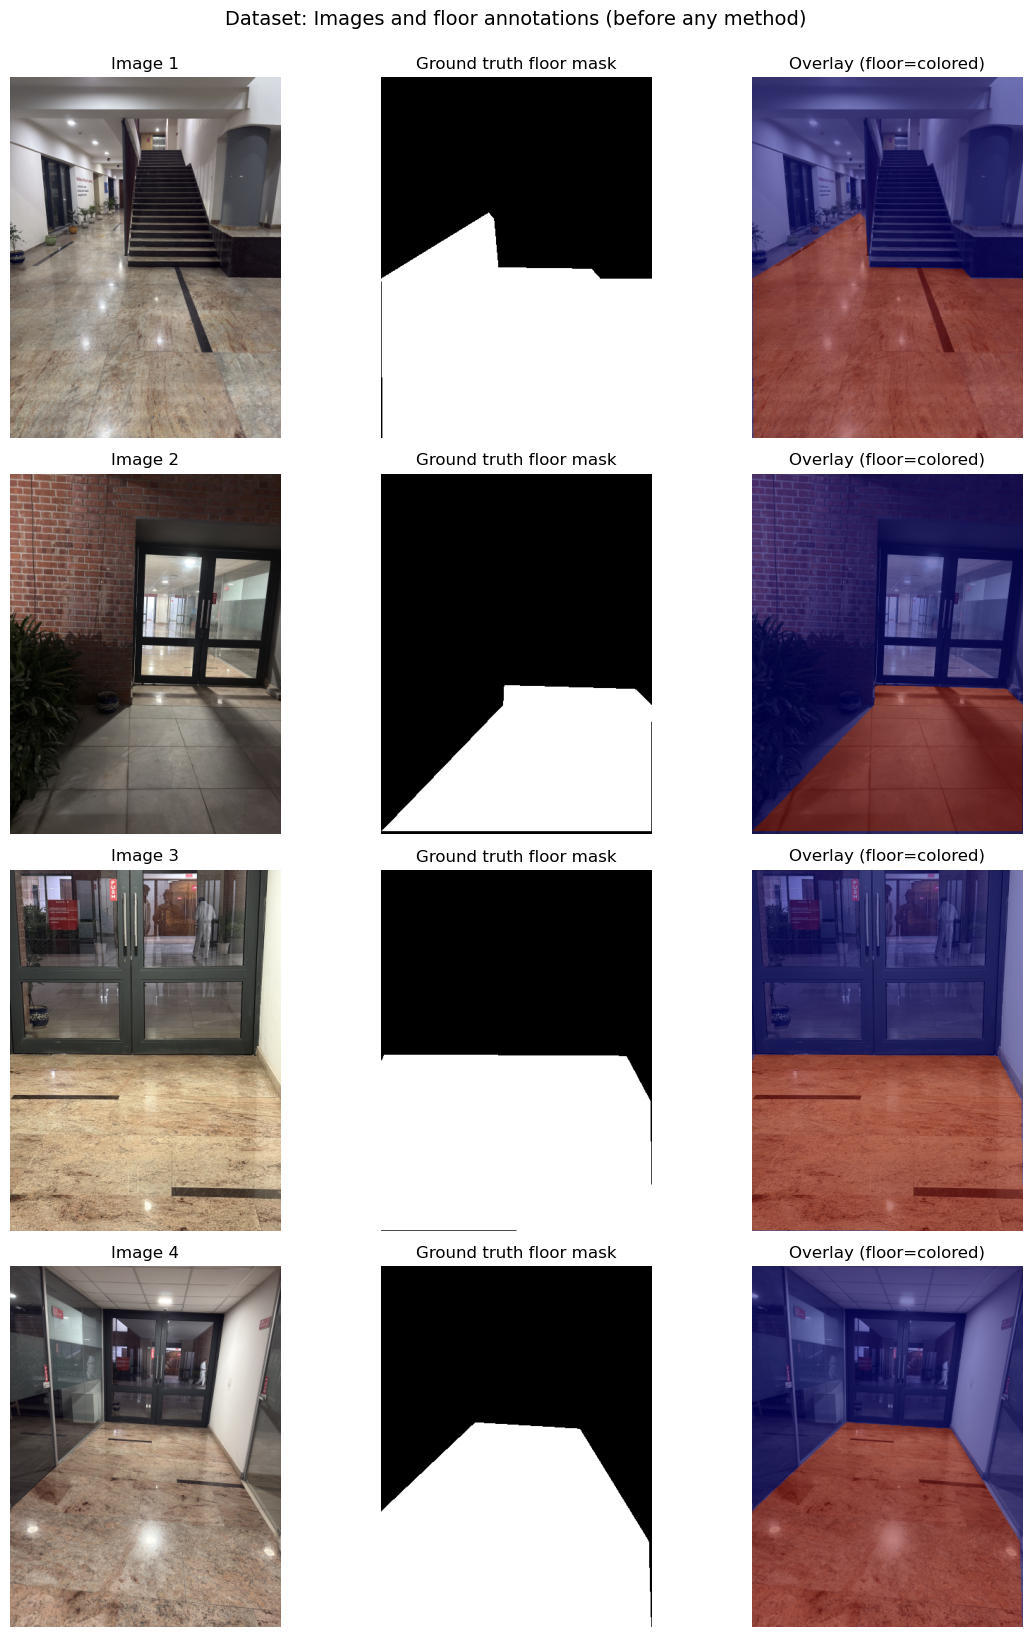

In [8]:
# Show first 4 image-mask pairs
n_show = min(4, len(images))
fig, axes = plt.subplots(n_show, 3, figsize=(12, 4 * n_show))
for i in range(n_show):
    axes[i, 0].imshow(images[i])
    axes[i, 0].set_title(f"Image {i+1}")
    axes[i, 0].axis("off")
    axes[i, 1].imshow(masks[i], cmap="gray")
    axes[i, 1].set_title("Ground truth floor mask")
    axes[i, 1].axis("off")
    axes[i, 2].imshow(images[i])
    axes[i, 2].imshow(masks[i], cmap="jet", alpha=0.5)
    axes[i, 2].set_title("Overlay (floor=colored)")
    axes[i, 2].axis("off")
plt.tight_layout()
plt.suptitle("Dataset: Images and floor annotations (before any method)", y=1.02, fontsize=14)
plt.show()

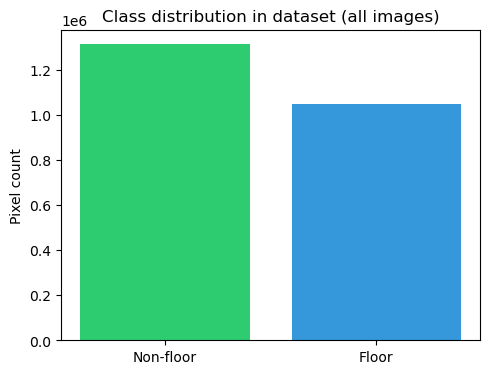

Floor pixels: 1047395, Non-floor: 1311901, Total: 2359296


In [9]:
# Class balance in masks (floor vs non-floor pixels)
floor_pixels = sum(m.sum() for m in masks)
total_pixels = sum(m.size for m in masks)
non_floor_pixels = total_pixels - floor_pixels
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.bar(["Non-floor", "Floor"], [non_floor_pixels, floor_pixels], color=["#2ecc71", "#3498db"])
ax.set_ylabel("Pixel count")
ax.set_title("Class distribution in dataset (all images)")
plt.tight_layout()
plt.show()
print(f"Floor pixels: {floor_pixels}, Non-floor: {non_floor_pixels}, Total: {total_pixels}")

---
## Method 1: RGB only (bottom-half pixels)

Features: **R, G, B** for each pixel in the bottom half of the image. No spatial information.

In [10]:
def extract_bottom_half_pixels(image, mask, max_pixels=5000):
    """Extract RGB features from bottom half; label from mask. Optionally subsample."""
    H, W, _ = image.shape
    start_row = H // 2
    X, y = [], []
    for row in range(start_row, H):
        for col in range(W):
            r, g, b = image[row, col]
            label = mask[row, col]
            X.append([r, g, b])
            y.append(label)
    X = np.array(X)
    y = np.array(y)
    if len(X) > max_pixels:
        idx = np.random.choice(len(X), max_pixels, replace=False)
        X, y = X[idx], y[idx]
    return X, y

In [11]:
# Build dataset for Method 1
X_all_m1, y_all_m1 = [], []
for image, mask in zip(images, masks):
    X, y = extract_bottom_half_pixels(image, mask)
    X_all_m1.append(X)
    y_all_m1.append(y)
X_all_m1 = np.vstack(X_all_m1)
y_all_m1 = np.hstack(y_all_m1)
print("Method 1 dataset shape:", X_all_m1.shape, y_all_m1.shape)
print("Class counts:", np.bincount(y_all_m1))

Method 1 dataset shape: (60000, 3) (60000,)
Class counts: [14764 45236]


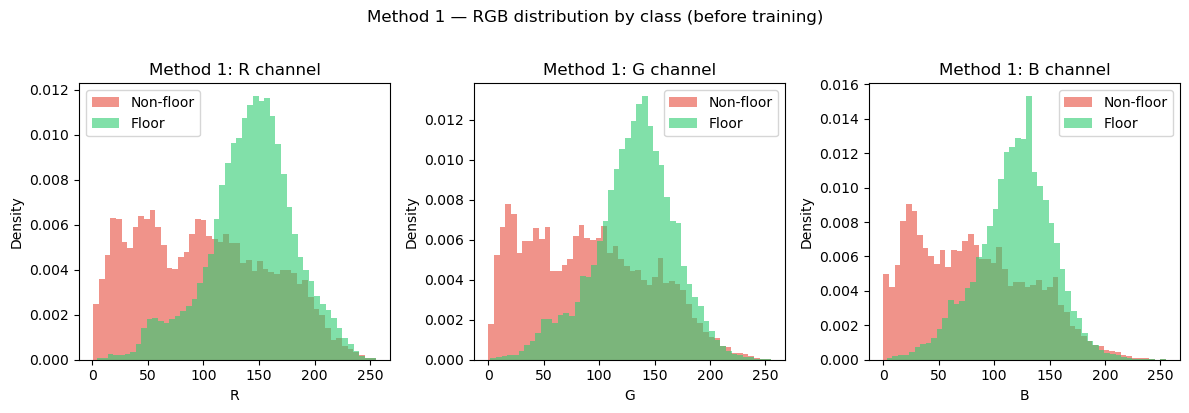

In [12]:
# Method 1: Feature distribution (RGB) — floor vs non-floor
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
colors = ["#e74c3c", "#2ecc71"]
for i, name in enumerate(["R", "G", "B"]):
    axes[i].hist(X_all_m1[y_all_m1 == 0, i], bins=50, alpha=0.6, label="Non-floor", color=colors[0], density=True)
    axes[i].hist(X_all_m1[y_all_m1 == 1, i], bins=50, alpha=0.6, label="Floor", color=colors[1], density=True)
    axes[i].set_xlabel(name)
    axes[i].set_ylabel("Density")
    axes[i].set_title(f"Method 1: {name} channel")
    axes[i].legend()
plt.suptitle("Method 1 — RGB distribution by class (before training)", y=1.02)
plt.tight_layout()
plt.show()

In [13]:
# Train/test split and scale
X_train_m1, X_test_m1, y_train_m1, y_test_m1 = train_test_split(
    X_all_m1, y_all_m1, test_size=0.2, random_state=42, stratify=y_all_m1
)
scaler_m1 = StandardScaler()
X_train_m1 = scaler_m1.fit_transform(X_train_m1)
X_test_m1 = scaler_m1.transform(X_test_m1)

In [14]:
# Train SVM — Method 1
start_m1 = time.time()
svm_m1 = SVC(kernel="rbf", C=10, gamma="scale", class_weight="balanced")
svm_m1.fit(X_train_m1, y_train_m1)
train_time_m1 = time.time() - start_m1
print(f"Method 1 — Training time: {train_time_m1:.4f} seconds")

Method 1 — Training time: 30.4781 seconds


In [15]:
# Method 1 — Predictions and metrics
y_pred_m1 = svm_m1.predict(X_test_m1)
acc_m1 = accuracy_score(y_test_m1, y_pred_m1)
print("Method 1 — Classification report:")
print(classification_report(y_test_m1, y_pred_m1, target_names=["Non-floor", "Floor"]))
print("Method 1 — Accuracy:", acc_m1)

Method 1 — Classification report:
              precision    recall  f1-score   support

   Non-floor       0.54      0.68      0.61      2953
       Floor       0.89      0.81      0.85      9047

    accuracy                           0.78     12000
   macro avg       0.71      0.75      0.73     12000
weighted avg       0.80      0.78      0.79     12000

Method 1 — Accuracy: 0.7803333333333333


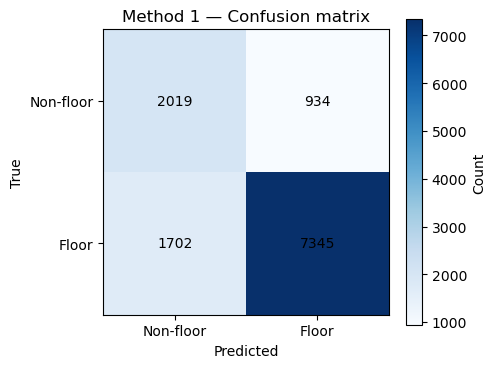

In [16]:
# Method 1 — Confusion matrix
cm_m1 = confusion_matrix(y_test_m1, y_pred_m1)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(cm_m1, cmap="Blues")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Non-floor", "Floor"])
ax.set_yticklabels(["Non-floor", "Floor"])
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_m1[i, j], ha="center", va="center", color="black")
plt.colorbar(im, ax=ax, label="Count")
ax.set_title("Method 1 — Confusion matrix")
plt.tight_layout()
plt.show()

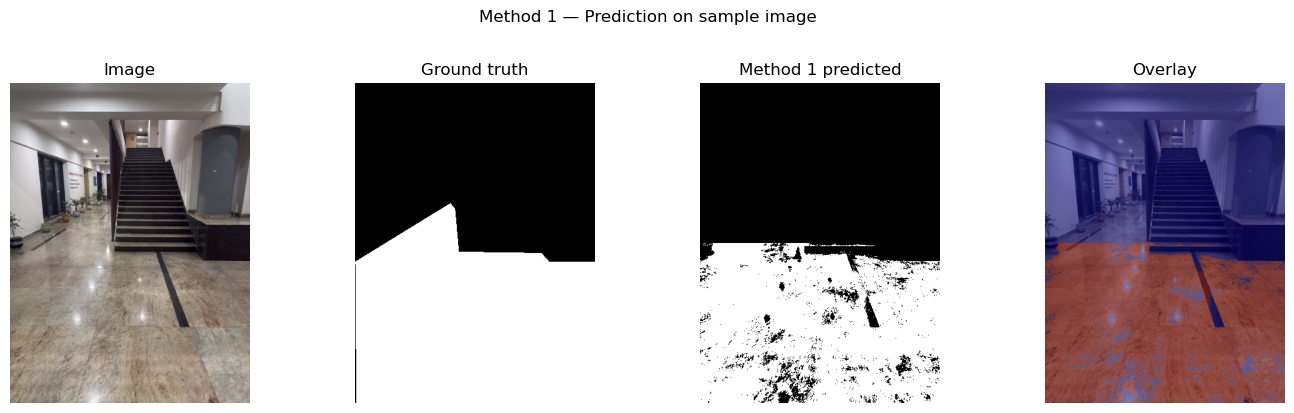

In [17]:
# Method 1 — Visualize prediction on one image (bottom half only)
idx_demo = 0
img_demo, mask_demo = images[idx_demo], masks[idx_demo]
H, W = img_demo.shape[:2]
start_row = H // 2
X_demo = []
positions = []
for row in range(start_row, H):
    for col in range(W):
        X_demo.append(img_demo[row, col])
        positions.append((row, col))
X_demo = np.array(X_demo)
X_demo_scaled = scaler_m1.transform(X_demo)
pred_demo = svm_m1.predict(X_demo_scaled)
pred_mask = np.zeros((H, W), dtype=np.uint8)
for (r, c), p in zip(positions, pred_demo):
    pred_mask[r, c] = p

fig, axes = plt.subplots(1, 4, figsize=(14, 4))
axes[0].imshow(img_demo)
axes[0].set_title("Image")
axes[0].axis("off")
axes[1].imshow(mask_demo, cmap="gray")
axes[1].set_title("Ground truth")
axes[1].axis("off")
axes[2].imshow(pred_mask, cmap="gray")
axes[2].set_title("Method 1 predicted")
axes[2].axis("off")
axes[3].imshow(img_demo)
axes[3].imshow(pred_mask, cmap="jet", alpha=0.5)
axes[3].set_title("Overlay")
axes[3].axis("off")
plt.suptitle("Method 1 — Prediction on sample image", y=1.02)
plt.tight_layout()
plt.show()

---
## Method 2: RGB + normalized (x, y) (bottom-half pixels)

Features: **R, G, B, x_norm, y_norm** so the model can use position in the image.

In [18]:
def extract_bottom_half_pixels_rgb_xy(image, mask, max_pixels=5000):
    """Extract RGB + normalized (x,y) from bottom half."""
    H, W, _ = image.shape
    start_row = H // 2
    X, y = [], []
    for row in range(start_row, H):
        for col in range(W):
            r, g, b = image[row, col]
            label = mask[row, col]
            x_norm = col / W
            y_norm = row / H
            X.append([r, g, b, x_norm, y_norm])
            y.append(label)
    X = np.array(X)
    y = np.array(y)
    if len(X) > max_pixels:
        idx = np.random.choice(len(X), max_pixels, replace=False)
        X, y = X[idx], y[idx]
    return X, y

In [19]:
# Build dataset for Method 2
X_all_m2, y_all_m2 = [], []
for image, mask in zip(images, masks):
    X, y = extract_bottom_half_pixels_rgb_xy(image, mask)
    X_all_m2.append(X)
    y_all_m2.append(y)
X_all_m2 = np.vstack(X_all_m2)
y_all_m2 = np.hstack(y_all_m2)
print("Method 2 dataset shape:", X_all_m2.shape, y_all_m2.shape)

Method 2 dataset shape: (60000, 5) (60000,)


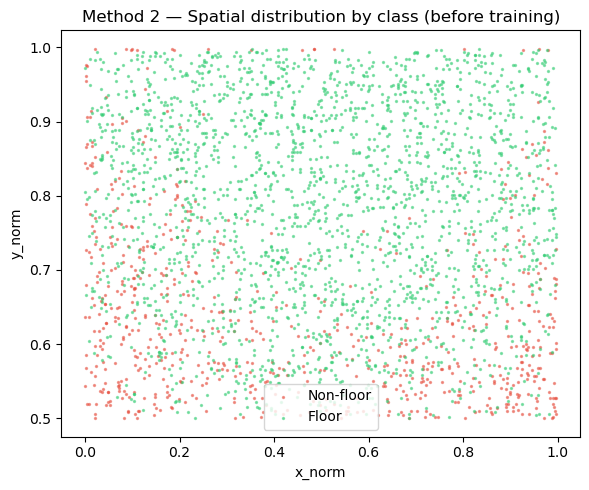

In [20]:
# Method 2: Spatial (x_norm, y_norm) scatter — floor vs non-floor (subsample for plot)
n_plot = min(3000, len(X_all_m2))
idx_plot = np.random.choice(len(X_all_m2), n_plot, replace=False)
Xp, yp = X_all_m2[idx_plot], y_all_m2[idx_plot]
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(Xp[yp == 0, 3], Xp[yp == 0, 4], s=2, alpha=0.5, c="#e74c3c", label="Non-floor")
ax.scatter(Xp[yp == 1, 3], Xp[yp == 1, 4], s=2, alpha=0.5, c="#2ecc71", label="Floor")
ax.set_xlabel("x_norm")
ax.set_ylabel("y_norm")
ax.set_title("Method 2 — Spatial distribution by class (before training)")
ax.legend()
plt.tight_layout()
plt.show()

In [21]:
# Train/test split and scale — Method 2
X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(
    X_all_m2, y_all_m2, test_size=0.2, random_state=42, stratify=y_all_m2
)
scaler_m2 = StandardScaler()
X_train_m2 = scaler_m2.fit_transform(X_train_m2)
X_test_m2 = scaler_m2.transform(X_test_m2)

In [22]:
# Train SVM — Method 2
start_m2 = time.time()
svm_m2 = SVC(kernel="rbf", C=10, gamma="scale", class_weight="balanced")
svm_m2.fit(X_train_m2, y_train_m2)
train_time_m2 = time.time() - start_m2
print(f"Method 2 — Training time: {train_time_m2:.4f} seconds")

Method 2 — Training time: 18.4607 seconds


In [23]:
# Method 2 — Predictions and metrics
y_pred_m2 = svm_m2.predict(X_test_m2)
acc_m2 = accuracy_score(y_test_m2, y_pred_m2)
print("Method 2 — Classification report:")
print(classification_report(y_test_m2, y_pred_m2, target_names=["Non-floor", "Floor"]))
print("Method 2 — Accuracy:", acc_m2)

Method 2 — Classification report:
              precision    recall  f1-score   support

   Non-floor       0.67      0.88      0.76      2964
       Floor       0.96      0.86      0.90      9036

    accuracy                           0.86     12000
   macro avg       0.81      0.87      0.83     12000
weighted avg       0.88      0.86      0.87     12000

Method 2 — Accuracy: 0.8610833333333333


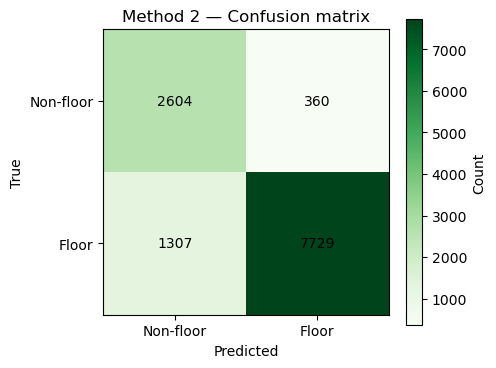

In [24]:
# Method 2 — Confusion matrix
cm_m2 = confusion_matrix(y_test_m2, y_pred_m2)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(cm_m2, cmap="Greens")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Non-floor", "Floor"])
ax.set_yticklabels(["Non-floor", "Floor"])
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_m2[i, j], ha="center", va="center", color="black")
plt.colorbar(im, ax=ax, label="Count")
ax.set_title("Method 2 — Confusion matrix")
plt.tight_layout()
plt.show()

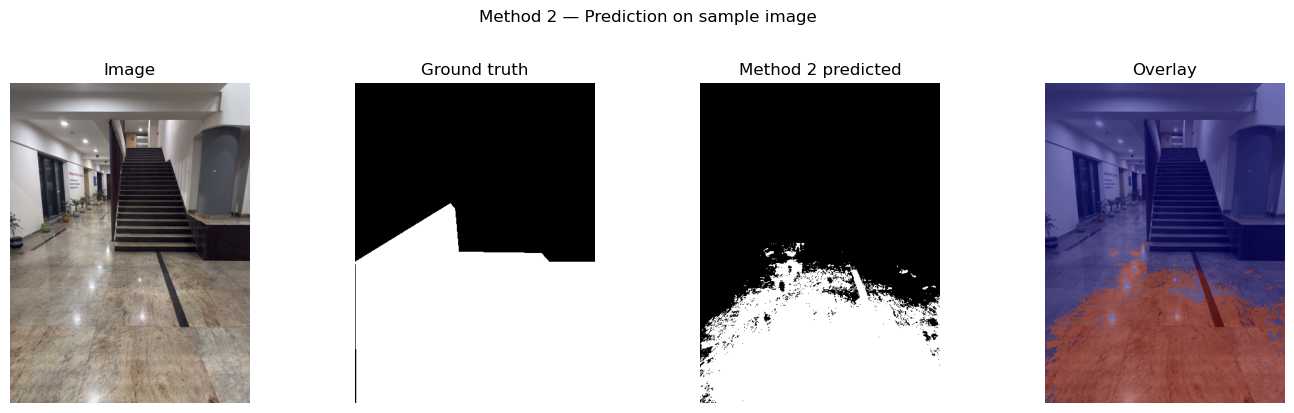

In [25]:
# Method 2 — Prediction overlay on sample image
idx_demo = 0
img_demo, mask_demo = images[idx_demo], masks[idx_demo]
H, W = img_demo.shape[:2]
start_row = H // 2
X_demo2, positions2 = [], []
for row in range(start_row, H):
    for col in range(W):
        r, g, b = img_demo[row, col]
        X_demo2.append([r, g, b, col / W, row / H])
        positions2.append((row, col))
X_demo2 = scaler_m2.transform(np.array(X_demo2))
pred_demo2 = svm_m2.predict(X_demo2)
pred_mask2 = np.zeros((H, W), dtype=np.uint8)
for (r, c), p in zip(positions2, pred_demo2):
    pred_mask2[r, c] = p

fig, axes = plt.subplots(1, 4, figsize=(14, 4))
axes[0].imshow(img_demo)
axes[0].set_title("Image")
axes[0].axis("off")
axes[1].imshow(mask_demo, cmap="gray")
axes[1].set_title("Ground truth")
axes[1].axis("off")
axes[2].imshow(pred_mask2, cmap="gray")
axes[2].set_title("Method 2 predicted")
axes[2].axis("off")
axes[3].imshow(img_demo)
axes[3].imshow(pred_mask2, cmap="jet", alpha=0.5)
axes[3].set_title("Overlay")
axes[3].axis("off")
plt.suptitle("Method 2 — Prediction on sample image", y=1.02)
plt.tight_layout()
plt.show()

---
## Method 3: KMeans region-level features

Pixels are clustered with KMeans; each region is one sample with **mean RGB + normalized centroid (x, y)** and label = majority vote from mask.

In [26]:
def extract_region_features(image, mask, n_clusters=100):
    """KMeans on pixels -> regions; each region: mean RGB + centroid (x_norm, y_norm), label = majority in mask.
    Returns X_regions, y_regions, labels_2d, valid_region_ids (order of rows in X_regions)."""
    H, W, _ = image.shape
    pixels = image.reshape(-1, 3).astype(np.float32)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(pixels)
    labels_2d = labels.reshape(H, W)

    X_regions, y_regions, valid_region_ids = [], [], []
    for region_id in range(n_clusters):
        region_pixels = (labels_2d == region_id)
        if np.sum(region_pixels) == 0:
            continue
        valid_region_ids.append(region_id)
        mean_rgb = image[region_pixels].mean(axis=0)
        rows, cols = np.where(region_pixels)
        y_mean = rows.mean() / H
        x_mean = cols.mean() / W
        region_labels = mask[region_pixels]
        region_label = int(np.mean(region_labels) >= 0.5)
        X_regions.append([mean_rgb[0], mean_rgb[1], mean_rgb[2], x_mean, y_mean])
        y_regions.append(region_label)
    return np.array(X_regions), np.array(y_regions), labels_2d, valid_region_ids

In [27]:
# Build dataset for Method 3 (collect region features from all images)
N_CLUSTERS = 100
X_all_m3, y_all_m3 = [], []
for image, mask in zip(images, masks):
    X_regions, y_regions, _, _ = extract_region_features(image, mask, n_clusters=N_CLUSTERS)
    X_all_m3.append(X_regions)
    y_all_m3.append(y_regions)
X_all_m3 = np.vstack(X_all_m3)
y_all_m3 = np.hstack(y_all_m3)
print("Method 3 dataset shape:", X_all_m3.shape, y_all_m3.shape)
print("Class counts:", np.bincount(y_all_m3))

Method 3 dataset shape: (1200, 5) (1200,)
Class counts: [757 443]


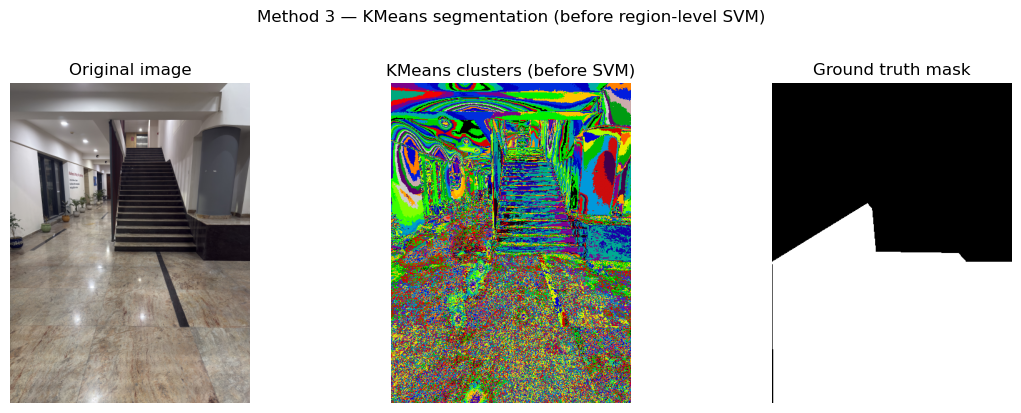

In [28]:
# Method 3 — BEFORE: Visualize KMeans clusters on one image
idx_c = 0
_, _, labels_2d, _ = extract_region_features(images[idx_c], masks[idx_c], n_clusters=N_CLUSTERS)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(images[idx_c])
axes[0].set_title("Original image")
axes[0].axis("off")
axes[1].imshow(labels_2d, cmap="nipy_spectral")
axes[1].set_title("KMeans clusters (before SVM)")
axes[1].axis("off")
axes[2].imshow(masks[idx_c], cmap="gray")
axes[2].set_title("Ground truth mask")
axes[2].axis("off")
plt.suptitle("Method 3 — KMeans segmentation (before region-level SVM)", y=1.02)
plt.tight_layout()
plt.show()

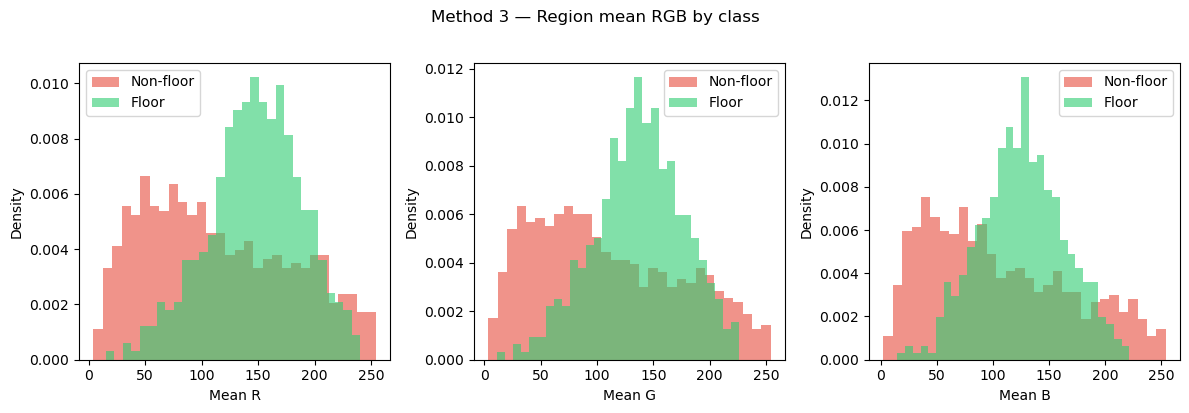

In [29]:
# Method 3 — Region feature distribution (mean R, G, B by class)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, name in enumerate(["Mean R", "Mean G", "Mean B"]):
    axes[i].hist(X_all_m3[y_all_m3 == 0, i], bins=30, alpha=0.6, label="Non-floor", color="#e74c3c", density=True)
    axes[i].hist(X_all_m3[y_all_m3 == 1, i], bins=30, alpha=0.6, label="Floor", color="#2ecc71", density=True)
    axes[i].set_xlabel(name)
    axes[i].set_ylabel("Density")
    axes[i].legend()
plt.suptitle("Method 3 — Region mean RGB by class", y=1.02)
plt.tight_layout()
plt.show()

In [30]:
# Train/test split and scale — Method 3
X_train_m3, X_test_m3, y_train_m3, y_test_m3 = train_test_split(
    X_all_m3, y_all_m3, test_size=0.2, random_state=42, stratify=y_all_m3
)
scaler_m3 = StandardScaler()
X_train_m3 = scaler_m3.fit_transform(X_train_m3)
X_test_m3 = scaler_m3.transform(X_test_m3)

In [31]:
# Train SVM — Method 3
start_m3 = time.time()
svm_m3 = SVC(kernel="rbf", C=10, gamma="scale", class_weight="balanced")
svm_m3.fit(X_train_m3, y_train_m3)
train_time_m3 = time.time() - start_m3
print(f"Method 3 — Training time: {train_time_m3:.4f} seconds")

Method 3 — Training time: 0.0083 seconds


In [32]:
# Method 3 — Predictions and metrics
y_pred_m3 = svm_m3.predict(X_test_m3)
acc_m3 = accuracy_score(y_test_m3, y_pred_m3)
print("Method 3 — Classification report:")
print(classification_report(y_test_m3, y_pred_m3, target_names=["Non-floor", "Floor"]))
print("Method 3 — Accuracy:", acc_m3)

Method 3 — Classification report:
              precision    recall  f1-score   support

   Non-floor       0.97      0.91      0.94       151
       Floor       0.87      0.94      0.90        89

    accuracy                           0.93       240
   macro avg       0.92      0.93      0.92       240
weighted avg       0.93      0.93      0.93       240

Method 3 — Accuracy: 0.925


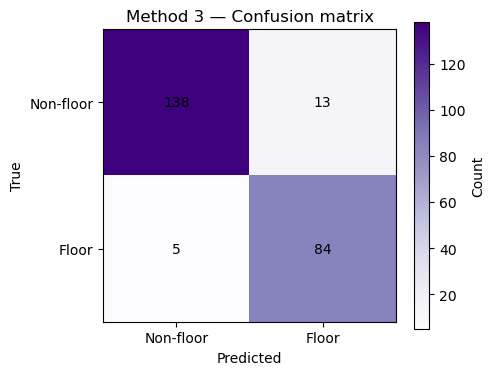

In [33]:
# Method 3 — Confusion matrix
cm_m3 = confusion_matrix(y_test_m3, y_pred_m3)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
im = ax.imshow(cm_m3, cmap="Purples")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Non-floor", "Floor"])
ax.set_yticklabels(["Non-floor", "Floor"])
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm_m3[i, j], ha="center", va="center", color="black")
plt.colorbar(im, ax=ax, label="Count")
ax.set_title("Method 3 — Confusion matrix")
plt.tight_layout()
plt.show()

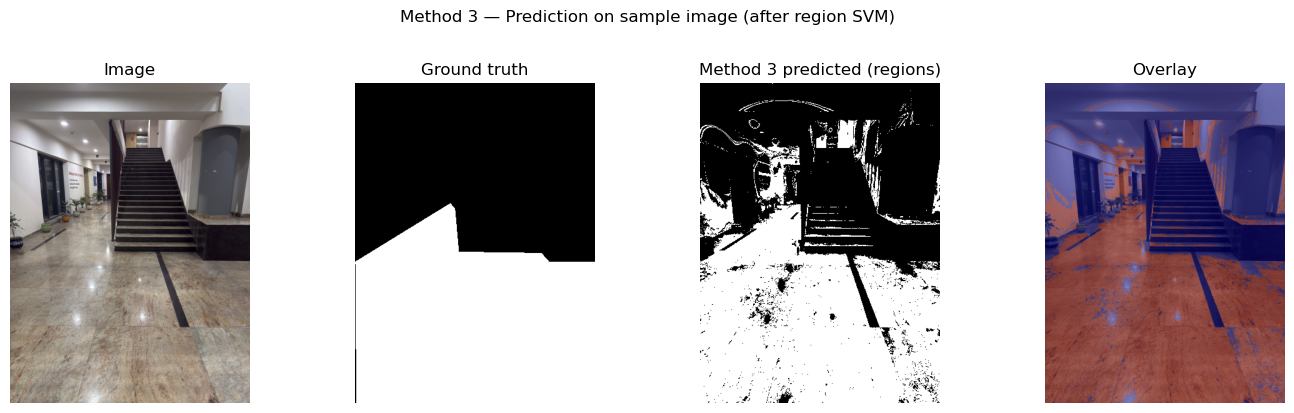

In [34]:
# Method 3 — AFTER: Prediction overlay (region-level -> image)
# Re-extract regions for demo image and predict per region
idx_demo = 0
X_reg_demo, y_reg_demo, labels_2d_demo, valid_region_ids = extract_region_features(
    images[idx_demo], masks[idx_demo], n_clusters=N_CLUSTERS
)
X_reg_demo_s = scaler_m3.transform(X_reg_demo)
region_preds = svm_m3.predict(X_reg_demo_s)
# Map each pixel to its region's prediction (valid_region_ids[i] -> region_preds[i])
pred_mask3 = np.zeros_like(labels_2d_demo, dtype=np.uint8)
for i, rid in enumerate(valid_region_ids):
    pred_mask3[labels_2d_demo == rid] = region_preds[i]

H, W = images[idx_demo].shape[:2]
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
axes[0].imshow(images[idx_demo])
axes[0].set_title("Image")
axes[0].axis("off")
axes[1].imshow(masks[idx_demo], cmap="gray")
axes[1].set_title("Ground truth")
axes[1].axis("off")
axes[2].imshow(pred_mask3, cmap="gray")
axes[2].set_title("Method 3 predicted (regions)")
axes[2].axis("off")
axes[3].imshow(images[idx_demo])
axes[3].imshow(pred_mask3, cmap="jet", alpha=0.5)
axes[3].set_title("Overlay")
axes[3].axis("off")
plt.suptitle("Method 3 — Prediction on sample image (after region SVM)", y=1.02)
plt.tight_layout()
plt.show()

---
## Final summary: comparison of all three methods

Accuracy, training time, and a side-by-side overview.

In [35]:
# Summary table
import pandas as pd
summary = pd.DataFrame({
    "Method": ["1 — RGB only", "2 — RGB + (x,y)", "3 — KMeans regions"],
    "Accuracy": [acc_m1, acc_m2, acc_m3],
    "Train_time_sec": [train_time_m1, train_time_m2, train_time_m3],
})
print(summary.to_string(index=False))

            Method  Accuracy  Train_time_sec
      1 — RGB only  0.780333       30.478142
   2 — RGB + (x,y)  0.861083       18.460737
3 — KMeans regions  0.925000        0.008316


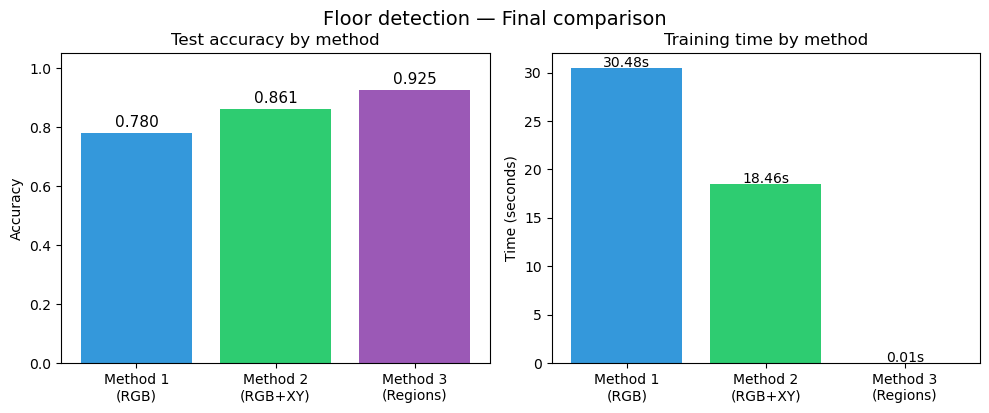

In [36]:
# Bar charts: Accuracy and training time
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
methods = ["Method 1\n(RGB)", "Method 2\n(RGB+XY)", "Method 3\n(Regions)"]
accs = [acc_m1, acc_m2, acc_m3]
times = [train_time_m1, train_time_m2, train_time_m3]
axes[0].bar(methods, accs, color=["#3498db", "#2ecc71", "#9b59b6"])
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Test accuracy by method")
axes[0].set_ylim(0, 1.05)
for i, v in enumerate(accs):
    axes[0].text(i, v + 0.02, f"{v:.3f}", ha="center", fontsize=11)
axes[1].bar(methods, times, color=["#3498db", "#2ecc71", "#9b59b6"])
axes[1].set_ylabel("Time (seconds)")
axes[1].set_title("Training time by method")
for i, v in enumerate(times):
    axes[1].text(i, v + 0.1, f"{v:.2f}s", ha="center", fontsize=10)
plt.tight_layout()
plt.suptitle("Floor detection — Final comparison", y=1.02, fontsize=14)
plt.show()

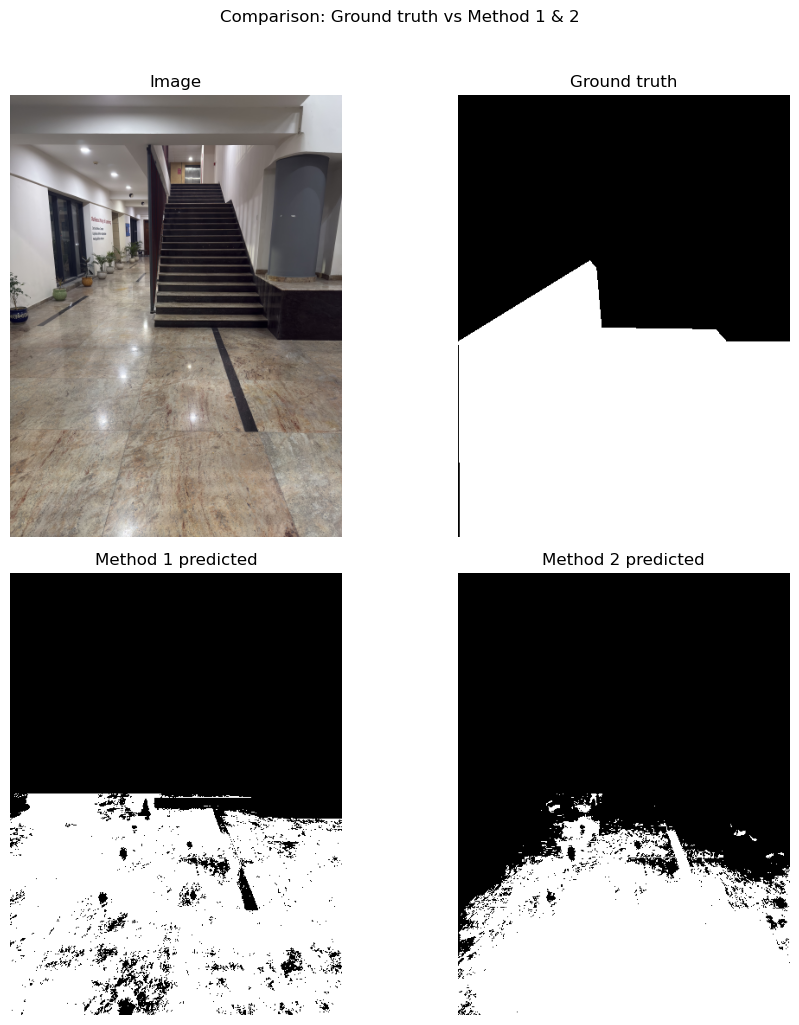

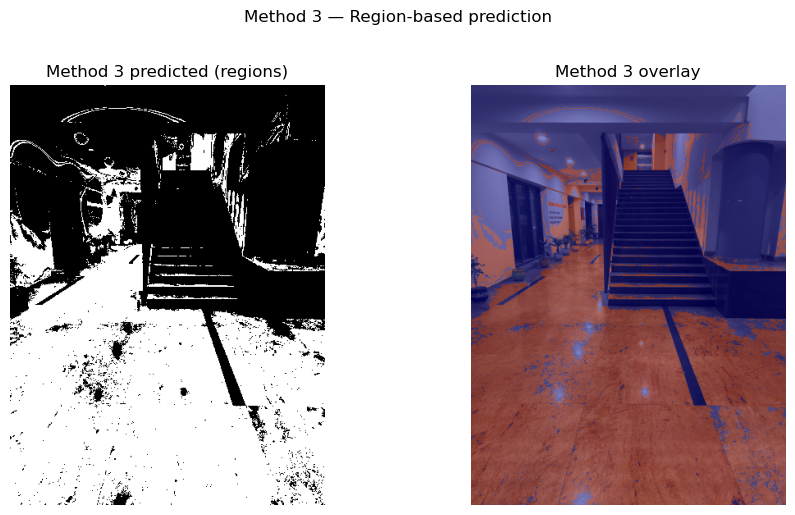

In [37]:
# Side-by-side predicted masks on same image (all three methods)
idx_final = 0
img_f = images[idx_final]
mask_gt = masks[idx_final]
H, W = img_f.shape[:2]
start_row = H // 2

# Method 1
X1, pos1 = [], []
for r in range(start_row, H):
    for c in range(W):
        X1.append(img_f[r, c])
        pos1.append((r, c))
X1 = scaler_m1.transform(np.array(X1))
p1 = svm_m1.predict(X1)
mask1 = np.zeros((H, W), dtype=np.uint8)
for (r, c), v in zip(pos1, p1):
    mask1[r, c] = v

# Method 2
X2, pos2 = [], []
for r in range(start_row, H):
    for c in range(W):
        X2.append([*img_f[r, c], c / W, r / H])
        pos2.append((r, c))
X2 = scaler_m2.transform(np.array(X2))
p2 = svm_m2.predict(X2)
mask2 = np.zeros((H, W), dtype=np.uint8)
for (r, c), v in zip(pos2, p2):
    mask2[r, c] = v

# Method 3
X_reg_f, _, labels_2d_f, valid_ids_f = extract_region_features(img_f, mask_gt, n_clusters=N_CLUSTERS)
X3_s = scaler_m3.transform(X_reg_f)
p3 = svm_m3.predict(X3_s)
mask3 = np.zeros((H, W), dtype=np.uint8)
for i, vid in enumerate(valid_ids_f):
    mask3[labels_2d_f == vid] = p3[i]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(img_f)
axes[0, 0].set_title("Image")
axes[0, 0].axis("off")
axes[0, 1].imshow(mask_gt, cmap="gray")
axes[0, 1].set_title("Ground truth")
axes[0, 1].axis("off")
axes[1, 0].imshow(mask1, cmap="gray")
axes[1, 0].set_title("Method 1 predicted")
axes[1, 0].axis("off")
axes[1, 1].imshow(mask2, cmap="gray")
axes[1, 1].set_title("Method 2 predicted")
axes[1, 1].axis("off")
plt.suptitle("Comparison: Ground truth vs Method 1 & 2", y=1.02)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mask3, cmap="gray")
axes[0].set_title("Method 3 predicted (regions)")
axes[0].axis("off")
axes[1].imshow(img_f)
axes[1].imshow(mask3, cmap="jet", alpha=0.5)
axes[1].set_title("Method 3 overlay")
axes[1].axis("off")
plt.suptitle("Method 3 — Region-based prediction", y=1.02)
plt.tight_layout()
plt.show()

In [38]:
# Final output summary
print("=" * 60)
print("FLOOR DETECTION — FINAL RESULTS (CMM dataset)")
print("=" * 60)
print(f"Dataset: {len(images)} images, annotations from {COCO_JSON}")
print(f"Images resized to max dimension: {MAX_IMAGE_DIM}")
print()
print("Method 1 (RGB only):")
print(f"  Test accuracy: {acc_m1:.4f}")
print(f"  Training time: {train_time_m1:.4f} s")
print()
print("Method 2 (RGB + x,y):")
print(f"  Test accuracy: {acc_m2:.4f}")
print(f"  Training time: {train_time_m2:.4f} s")
print()
print("Method 3 (KMeans regions):")
print(f"  Test accuracy: {acc_m3:.4f}")
print(f"  Training time: {train_time_m3:.4f} s")
print()
best = np.argmax([acc_m1, acc_m2, acc_m3])
print(f"Best accuracy: Method {best+1} ({[acc_m1,acc_m2,acc_m3][best]:.4f})")
print("=" * 60)

FLOOR DETECTION — FINAL RESULTS (CMM dataset)
Dataset: 12 images, annotations from dataset/CMM_Annotations.json
Images resized to max dimension: 512

Method 1 (RGB only):
  Test accuracy: 0.7803
  Training time: 30.4781 s

Method 2 (RGB + x,y):
  Test accuracy: 0.8611
  Training time: 18.4607 s

Method 3 (KMeans regions):
  Test accuracy: 0.9250
  Training time: 0.0083 s

Best accuracy: Method 3 (0.9250)
